In [1]:
from pathlib import Path

import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from ray import tune
from ray.air import Checkpoint, session

In [2]:
ray_results_path = Path("~/ray_results").expanduser()
assert ray_results_path.is_dir()

In [3]:
last_experiment = max(ray_results_path.glob('TrainLightGCN_*'), key=lambda x: x.stat().st_ctime)
print(f"Loading results from {last_experiment}...")
assert last_experiment.is_dir()

class TrainLightGCN:
    def __init__(self):
        raise NotImplementedError

# TODO: Create an experiment grid or whatever is called
tuner = tune.Tuner.restore(str(last_experiment), TrainLightGCN)
rg = tuner.get_results()
rg.get_best_result()

Loading results from /home/daviddavo/ray_results/TrainLightGCN_2023-11-12_20-13-31...


Result(
  metrics={'iteration': 200, 'loss': 0.00014836744854359753, 'mf_loss': 6.732341853421531e-05, 'emb_loss': 8.104402721593421e-05, 'model_recall': 0.0, 'model_ndcg': 0.0, 'model_precision': 0.0, 'model_map': 0.0, 'precision@5': 0.23703703703703707, 'ndcg@5': 0.43461596321466217, 'recall@5': 0.698941798941799, 'map@5': 0.3104232804232804, 'precision@10': 0.17777777777777778, 'ndcg@10': 0.5525028669252282, 'recall@10': 1.0, 'map@10': 0.39474342823549163},
  path='/home/daviddavo/ray_results/TrainLightGCN_2023-11-12_20-13-31/TrainLightGCN_253195d4_641_trial_index=0,batch_size=8,conv_layers=2,embedding_dim=90,l2=0.0000,learning_rate=0.0228_2023-11-13_18-40-36',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/home/daviddavo/ray_results/TrainLightGCN_2023-11-12_20-13-31/TrainLightGCN_253195d4_641_trial_index=0,batch_size=8,conv_layers=2,embedding_dim=90,l2=0.0000,learning_rate=0.0228_2023-11-13_18-40-36/checkpoint_000000)
)

In [5]:
# Read dataframe and drop some unneeded columns
rdf = rg.get_dataframe('precision@5', 'max').drop(columns=['timestamp', 'node_ip', 'pid', 'hostname', 'time_since_restore', 'iterations_since_restore', 'logdir'])
rdf = rdf.drop(columns=['date'])
# rdf = rdf[rdf['done']]
print(rdf.columns)

for c in ['config/batch_size']: #, 'config/embedding_dim']:
    rdf[c] = 2**rdf[c]

rdf[(rdf['config/__trial_index__'] >= 3) & (rdf['iteration'] > 10)].sort_values('precision@5').tail()

Index(['iteration', 'loss', 'mf_loss', 'emb_loss', 'model_recall',
       'model_ndcg', 'model_precision', 'model_map', 'precision@5', 'ndcg@5',
       'recall@5', 'map@5', 'precision@10', 'ndcg@10', 'recall@10', 'map@10',
       'done', 'training_iteration', 'trial_id', 'time_this_iter_s',
       'time_total_s', 'checkpoint_dir_name', 'config/batch_size',
       'config/embedding_dim', 'config/conv_layers', 'config/learning_rate',
       'config/l2', 'config/__trial_index__'],
      dtype='object')


,iteration,loss,mf_loss,emb_loss,model_recall,model_ndcg,model_precision,model_map,precision@5,ndcg@5,...,trial_id,time_this_iter_s,time_total_s,checkpoint_dir_name,config/batch_size,config/embedding_dim,config/conv_layers,config/learning_rate,config/l2,config/__trial_index__
13,160,0.032010,0.018312,0.013698,0.031267,0.033223,0.0224,0.019976,0.2880,0.492967,...,622d4b6a,8.220458,283.030658,None,512,230,3,0.0288,5.024596e-06,9
326,200,174.247947,4.333292,169.914655,0.080498,0.064582,0.0464,0.035119,0.2896,0.539725,...,eeb37533,369.332575,11370.628423,None,16,170,3,0.7374,2.033083e-02,9
151,135,0.530390,0.515522,0.014868,0.044533,0.038790,0.0336,0.022162,0.2896,0.433809,...,cfbbdf50,125.967606,4018.716840,None,32,200,2,0.0281,4.210334e-07,9
868,35,0.018794,0.015916,0.002878,0.033200,0.030150,0.0240,0.017856,0.2912,0.458743,...,dd17f608,313.998007,2242.291270,None,16,250,3,0.0063,3.680730e-06,9
792,20,3.796053,0.559920,3.236134,0.023000,0.014481,0.0096,0.007667,0.3040,0.496307,...,5de42a1b,17.905702,72.966309,None,256,185,4,0.2935,7.669483e-04,9


In [26]:
config_cols = [ c for c in rdf.columns if c.startswith('config/') and c not in ['config/__trial_index__', 'config/fold'] ]
print(config_cols)
print(len(rdf.groupby(config_cols)), 'configurations tested')

rdf.groupby(config_cols).mean(numeric_only=True).sort_values('precision@5').tail()

['config/batch_size', 'config/embedding_dim', 'config/conv_layers', 'config/learning_rate', 'config/l2']
100 configurations tested


,,,,,iteration,loss,mf_loss,emb_loss,model_recall,model_ndcg,model_precision,model_map,precision@5,ndcg@5,...,map@5,precision@10,ndcg@10,recall@10,map@10,done,training_iteration,time_this_iter_s,time_total_s,config/__trial_index__
config/batch_size,config/embedding_dim,config/conv_layers,config/learning_rate,config/l2,,,,,,,,,,,,,,,,,,,,,
64,25,2,0.5494,1.053371e-04,103.0,15.501050,11.443753,4.057297,0.053721,0.041908,0.017754,0.031716,0.217644,0.466080,...,0.371129,0.158368,0.532969,0.796792,0.418970,0.1,20.6,42.668438,600.076368,4.5
256,70,2,0.8648,5.780786e-06,100.5,20.064360,17.548191,2.516168,0.053564,0.044221,0.019757,0.034755,0.217931,0.464409,...,0.372854,0.157847,0.523515,0.759649,0.418480,0.0,20.1,12.380074,228.271992,4.5
128,110,5,0.0342,2.394405e-07,79.0,0.022029,0.021577,0.000452,0.055802,0.043796,0.020199,0.032401,0.219543,0.455284,...,0.360323,0.159524,0.521515,0.788169,0.407833,0.0,15.8,19.337504,312.603685,4.5
16,170,3,0.7374,2.033083e-02,87.0,114.858768,4.012912,110.845856,0.122459,0.082822,0.030913,0.063586,0.220991,0.506173,...,0.423117,0.158393,0.568715,0.784535,0.468574,0.1,17.4,125.818708,2080.066273,4.5
32,20,4,0.0478,3.119548e-04,77.0,0.071505,0.040358,0.031148,0.050365,0.043356,0.018182,0.035143,0.221452,0.498841,...,0.413985,0.157435,0.558401,0.781118,0.458990,0.0,15.4,57.234503,902.697869,4.5


In [27]:
ORG_NAME = 'Decentraland'
N_SPLITS = 10

bdf = pd.read_csv(f'./data/baseline/mp-{ORG_NAME}-{N_SPLITS}.csv')
bdf.mean()

precision@5     0.145534
ndcg@5          0.294985
map@5           0.233064
precision@10    0.136072
ndcg@10         0.396818
map@10          0.290771
precision@15    0.113898
ndcg@15         0.439916
map@15          0.311207
dtype: float64

## Doing some graphs

In [28]:
configs = rdf.groupby(config_cols).mean(numeric_only=True).reset_index()
configs = configs[configs['time_total_s'] < 300]
configs

,config/batch_size,config/embedding_dim,config/conv_layers,config/learning_rate,config/l2,iteration,loss,mf_loss,emb_loss,model_recall,...,map@5,precision@10,ndcg@10,recall@10,map@10,done,training_iteration,time_this_iter_s,time_total_s,config/__trial_index__
16,64,45,5,0.0042,2.161320e-06,78.0,0.026623,0.026373,0.000250,0.056142,...,0.322995,0.151793,0.484230,0.763380,0.369064,0.0,15.6,19.706151,271.962060,4.5
25,128,15,2,0.0230,4.958395e-04,42.5,0.042749,0.028910,0.013839,0.060607,...,0.337762,0.157677,0.501223,0.780560,0.384812,0.0,8.5,15.721868,125.034292,4.5
26,128,30,2,0.0009,1.005683e-07,66.0,0.077868,0.077866,0.000002,0.068446,...,0.339513,0.149497,0.493191,0.752764,0.383279,0.0,13.2,12.914887,105.509755,4.5
27,128,30,5,0.0007,2.270477e-05,90.5,0.118972,0.118172,0.000800,0.059054,...,0.324971,0.149902,0.486035,0.760159,0.372652,0.0,18.1,14.449138,268.202310,4.5
28,128,45,5,0.1018,1.993786e-06,60.5,0.121317,0.114681,0.006636,0.057286,...,0.345503,0.158058,0.508978,0.774322,0.394074,0.0,12.1,17.533824,151.419615,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,512,235,4,0.0008,1.011825e-07,87.0,0.054179,0.054175,0.000005,0.054049,...,0.307929,0.151505,0.478260,0.769161,0.360090,0.0,17.4,6.407934,117.429246,4.5
96,512,295,5,0.0016,1.087433e-05,93.5,0.042765,0.041918,0.000847,0.064154,...,0.324626,0.151332,0.487326,0.761300,0.373195,0.0,18.7,4.483949,84.677541,4.5
97,512,330,5,0.0452,3.567444e-06,61.0,0.035812,0.027806,0.008006,0.064690,...,0.360584,0.159005,0.525003,0.783343,0.413355,0.0,12.2,4.704469,62.152302,4.5
98,512,390,4,0.2041,1.297832e-06,91.0,0.978324,0.872614,0.105710,0.068206,...,0.348867,0.159263,0.512752,0.774931,0.400702,0.0,18.2,8.163514,131.989066,4.5


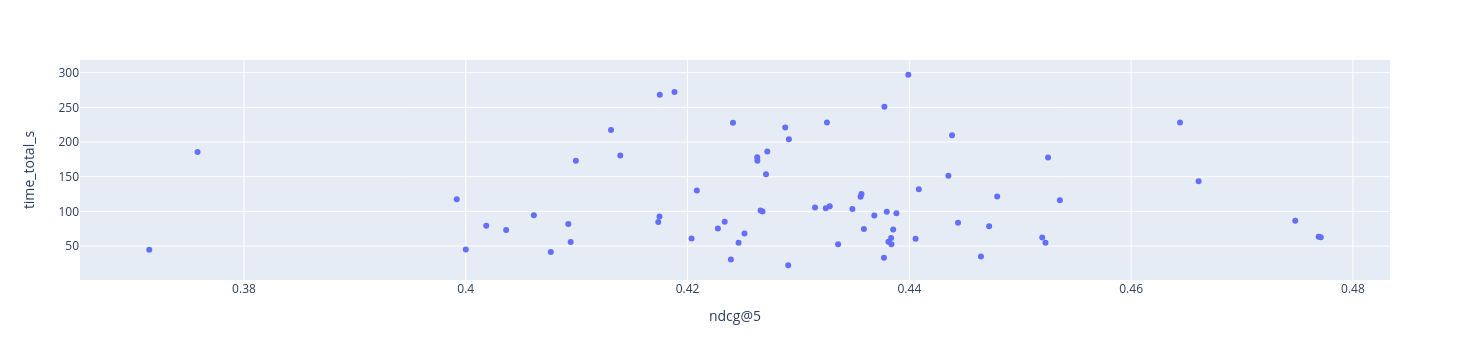

In [29]:
config_cols = [ c for c in configs.columns if c.startswith('config/') ]
px.scatter(configs, x='ndcg@5', y='time_total_s', hover_data=config_cols)

<Axes: xlabel='config/conv_layers', ylabel='ndcg@5'>

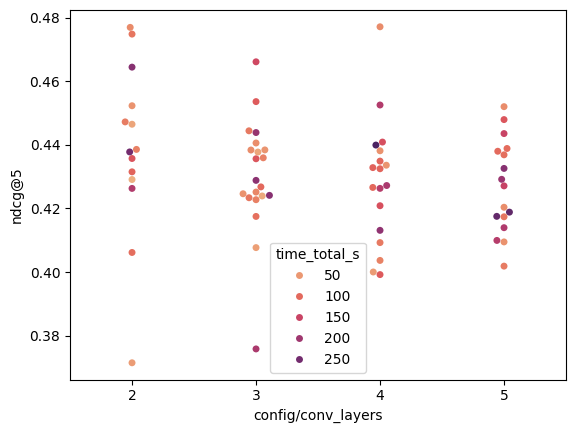

In [30]:
sns.swarmplot(configs, x='config/conv_layers', y='ndcg@5', hue='time_total_s', palette='flare')

<Axes: xlabel='config/batch_size', ylabel='ndcg@5'>

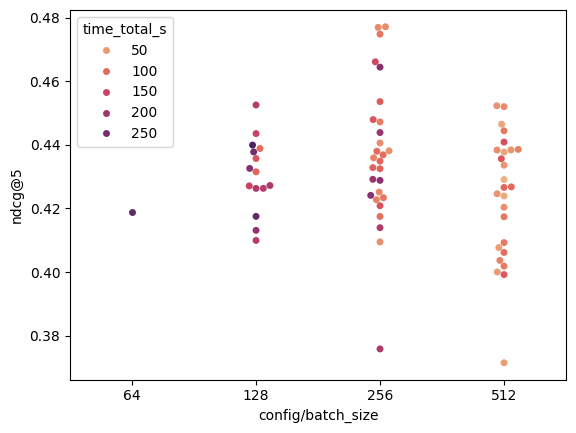

In [31]:
sns.swarmplot(configs, x='config/batch_size', y='ndcg@5', hue='time_total_s', palette='flare')
# plt.xscale('log', base=2)

<Axes: xlabel='config/batch_size', ylabel='time_total_s'>

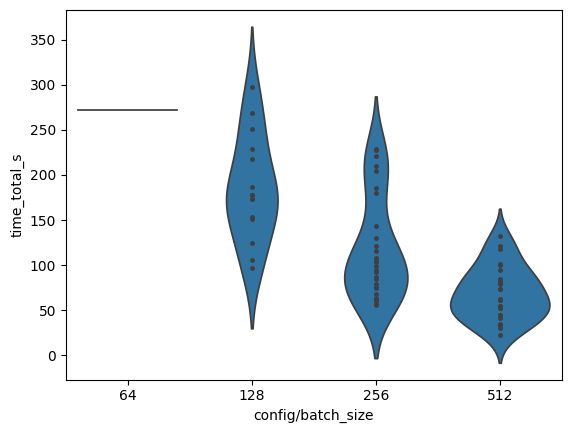

In [32]:
sns.violinplot(configs, x='config/batch_size', y='time_total_s', inner='point')

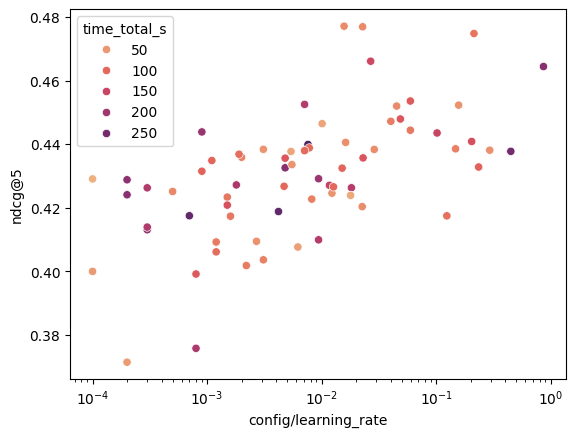

In [45]:
sns.scatterplot(configs, x='config/learning_rate', y='ndcg@5', hue='time_total_s', palette='flare')
plt.xscale('log')

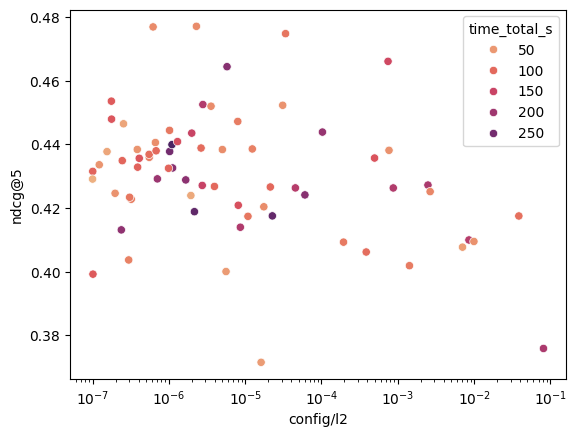

In [46]:
sns.scatterplot(configs, x='config/l2', y='ndcg@5', hue='time_total_s', palette='flare')
plt.xscale('log')

<Axes: xlabel='config/embedding_dim', ylabel='ndcg@5'>

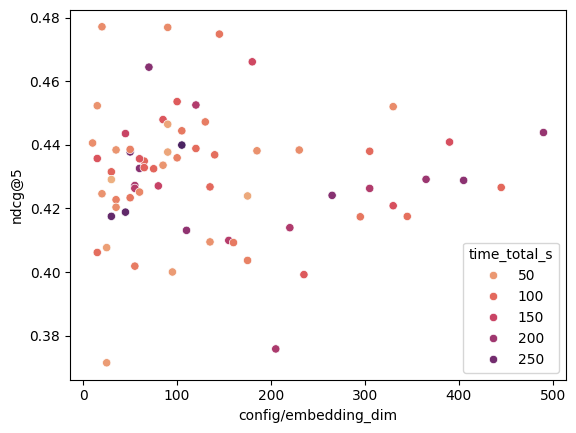

In [48]:
sns.scatterplot(configs, x='config/embedding_dim', y='ndcg@5', hue='time_total_s', palette='flare')